# Image Classification Using CNN
- Convolutional Neural Network for image classification

In [42]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100

In [43]:
# declare image labels
imagenette_map = { 
    "n01440764" : "tench",
    "n02102040" : "springer",
    "n02979186" : "casette_player",
    "n03000684" : "chain_saw",
    "n03028079" : "church",
    "n03394916" : "French_horn",
    "n03417042" : "garbage_truck",
    "n03425413" : "gas_pump",
    "n03445777" : "golf_ball",
    "n03888257" : "parachute"
}

In [44]:
# load dataset (using ImageNet  for objects classification)
# (X_train, y_train), (X_test, y_test) = cifar100.load_data()

# load imagenet dataset
image_generator = ImageDataGenerator()
train = image_generator.flow_from_directory("../data/imagenette2/train/", 
                                             class_mode="categorical", 
                                             shuffle=False, 
                                             batch_size=32, 
                                             target_size=(224, 224))

val = image_generator.flow_from_directory("../data/imagenette2/val/", 
                                           class_mode="categorical", 
                                           shuffle=False, 
                                           batch_size=32, 
                                           target_size=(224, 224))


Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [45]:
# # load image label
# class ConfigLoader():
#     def __init__(self):
#         self.file_obj = None

#     def loadYaml(self, filename):
#         """
#             Read Parameter file in the form of yml
#             The FullLoader parameter handles the conversion from YAML
#             Scalar values to Python the dictionary format
#         """
#         with open(f'{filename}', encoding='utf8') as file:
#             file_obj = yaml.load(file, Loader=yaml.FullLoader)
#         self.file_obj = file_obj
#         return self.file_obj
# labels = ConfigLoader().loadYaml("../data/CIFA100-labels.yml")['labels']
# labels

In [46]:
# # display an image: A picture of a cow
# print("Image Label: ", labels[y_train[0][0]])
# plt.figure(figsize = (5,5)) 
# plt.imshow(X_train[0], interpolation='none')

# Data Pre-Processing
Data normalization and clensing

In [47]:
# # generating a 32 x 32 x 3 input vector (for RGY)
# X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
# X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [48]:
# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

In [49]:
# declare the number of unique labels
# n_classes = len(set(y_train.reshape(1,-1)[0]))
n_classes = 10

# Model Building
Set up a convolutional network architecture to classify 100 class of images. Here, a 2 dimensional convolution is use because all images are flat.

In [50]:
def conv_net(image_shape, hidden_dimensions=[512, 256], dropout_rate=0.25):
    """
        setting up the Convolutional neural net
    """
    
    
    source_image = keras.layers.Input(shape=image_shape, dtype='float32', name='source_image')
    
    # add consecutive convolutional layers for RGY colors
    red_conv_layer = keras.layers.Conv2D(filters=100,
                                              input_shape=image_shape,
                                              kernel_size=(5,5), 
                                              strides=(1,1), 
                                              padding='same', 
                                              activation='relu',
                                              name='red_convolutional_layer')
    
    green_conv_layer = keras.layers.Conv2D(filters=100,
                                              kernel_size=(5,5), 
                                              strides=(1,1), 
                                              padding='same', 
                                              activation='relu',
                                              name='green_convolutional_layer')
    
    blue_conv_layer = keras.layers.Conv2D(filters=100,
                                              kernel_size=(5,5), 
                                              strides=(1,1), 
                                              padding='same', 
                                              activation='relu',
                                              name='blue_convolutional_layer')
    
    conv_out = blue_conv_layer(green_conv_layer(red_conv_layer(source_image)))
    
    # applying max pooling
    max_pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2), name='first_max_pooling_layer')
    max_pooling_out = max_pooling_layer(conv_out)
    max_pooling_out = keras.layers.Dropout(rate=dropout_rate)(max_pooling_out)

    
    # add more convolutional_layers
    # be sure to apply max pooling
    conv_layer = keras.layers.Conv2D(filters=125,
                                              kernel_size=(3,3), 
                                              strides=(1,1), 
                                              padding='same', 
                                              activation='relu',
                                              name='convolutional_layer')
    
    conv_out = conv_layer(max_pooling_out)
    max_pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))
    max_pooling_out = max_pooling_layer(conv_out)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(max_pooling_out)
    last_hidden_output = keras.layers.Flatten()(last_hidden_output)

    # add a fully connected feed-forward net
    # some final dropout layer
    # add final classification layer

    for hidden_layer_size in hidden_dimensions:
        last_hidden_output = keras.layers.Dense(hidden_layer_size, activation='relu')(last_hidden_output)

    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    image_classification = keras.layers.Dense(n_classes, activation='softmax')(last_hidden_output)

    # instantiate and compile the model
    conv_model = keras.Model(inputs=source_image, outputs=image_classification)
    conv_model.compile(optimizer='Adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    return conv_model

In [51]:
image_classificaiton_model = conv_net(image_shape=(32,32,3))
image_classificaiton_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_image (InputLayer)   [(None, 32, 32, 3)]       0         
                                                                 
 red_convolutional_layer (Co  (None, 32, 32, 100)      7600      
 nv2D)                                                           
                                                                 
 green_convolutional_layer (  (None, 32, 32, 100)      250100    
 Conv2D)                                                         
                                                                 
 blue_convolutional_layer (C  (None, 32, 32, 100)      250100    
 onv2D)                                                          
                                                                 
 first_max_pooling_layer (Ma  (None, 16, 16, 100)      0         
 xPooling2D)                                               

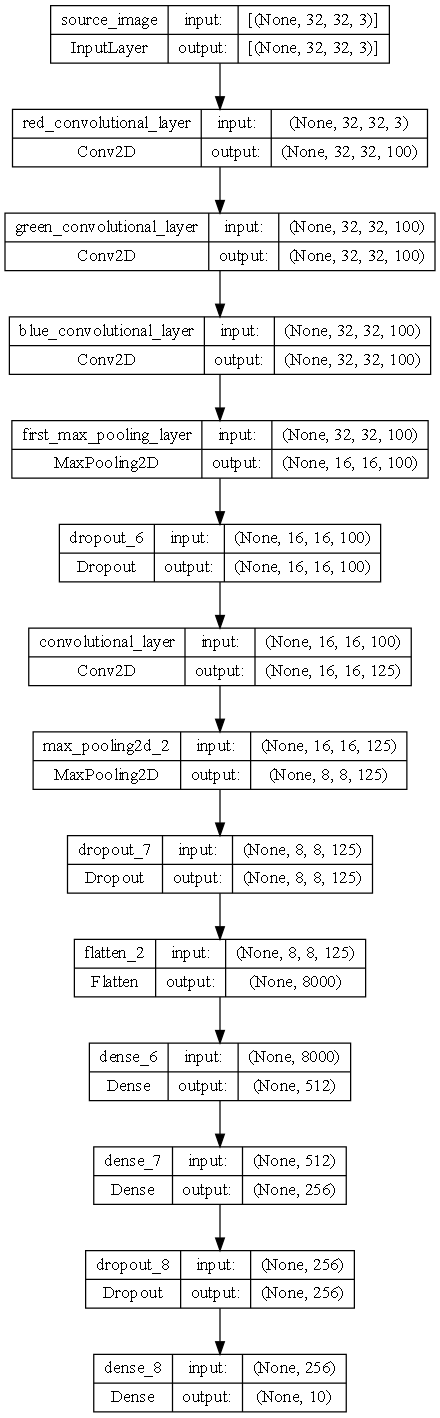

In [52]:
keras.utils.plot_model(image_classificaiton_model, show_shapes=True, dpi=90)

In [53]:
# train the model
# image_classificaiton_model.fit(X_train, y_train,
#                                validation_split=0.1,
#                                batch_size=256,
#                                epochs=20)

In [54]:
# train the model
image_classificaiton_model.fit(train,
                               validation_data=val,
                               epochs=30)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
      app.start()
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ktrin\AppData\Local\Temp\ipykernel_288\3049737726.py", line 2, in <cell line: 2>
      image_classificaiton_model.fit(train,
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 894, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\metrics\base_metric.py", line 646, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\metrics\metrics.py", line 3295, in categorical_accuracy
      return metrics_utils.sparse_categorical_matches(
    File "C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\keras\utils\metrics_utils.py", line 893, in sparse_categorical_matches
      matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_2509]

In [54]:
# all layers of CNN
CNN_model = image_classificaiton_model
CNN_model.layers

In [55]:
model2(X_test[0].reshape(1,32,32,3)).shape

# Preprocessing COCO Image Dataset
Load latest coco dataset/preporcessed it on caption

In [60]:
import json

train2017 = []
val2017 = []

# load in the data 
train_file = open("../data/annotations/captions_train2017.json")
val_file = open("../data//annotations/captions_val2017.json")
train_json = json.load(train_file)
val_json = json.load(val_file)
# train_json['caption']

def parse_image(json_data, output_list=train2017, mode="train"):
    """
        Class to parse image into a list of tuple
        -----------------------------------------
        Input:
        - json_data: dataset in json format
        - output_list: empty list to store the tuple of data
        - mode: either train dataset or validation dataset specification
        Output:
        - list of tuple
    """
    prepend_urL = ""
    if mode == "train":
        prepend_urL = "train2014/"
    elif mode == "validation":
        prepend_urL = "val2014/"
    else:
        print("Please Input Train or Validation for dataset parameters")
    
    # fetch the data in a workable format
    captions = json_data['annotations']
    images = {i["id"]: i["file_name"] for i in json_data['images']}

    # parse json data into a tuple to generate a list of tuples for both train/validation
    for caption in captions:
        image_id = caption['image_id']
        image_caption = caption['caption']
        image_url = prepend_urL+images[image_id]
        output_list.append((image_id, image_url, image_caption))
    return output_list


train2017 = parse_image(train_json, output_list=train2017, mode="train")
val2017 = parse_image(val_json, output_list=val2017, mode="validation")
print("Train:\n", train2017[:5])
print("Validation:\n", val2017[:5])


Train:
 [(203564, 'train2014/000000203564.jpg', 'A bicycle replica with a clock as the front wheel.'), (322141, 'train2014/000000322141.jpg', 'A room with blue walls and a white sink and door.'), (16977, 'train2014/000000016977.jpg', 'A car that seems to be parked illegally behind a legally parked car'), (106140, 'train2014/000000106140.jpg', 'A large passenger airplane flying through the air.'), (106140, 'train2014/000000106140.jpg', 'There is a GOL plane taking off in a partly cloudy sky.')]
Validation:
 [(179765, 'val2014/000000179765.jpg', 'A black Honda motorcycle parked in front of a garage.'), (179765, 'val2014/000000179765.jpg', 'A Honda motorcycle parked in a grass driveway'), (190236, 'val2014/000000190236.jpg', 'An office cubicle with four different types of computers.'), (331352, 'val2014/000000331352.jpg', 'A small closed toilet in a cramped space.'), (517069, 'val2014/000000517069.jpg', 'Two women waiting at a bench next to a street.')]


In [64]:
image_generator = ImageDataGenerator(rescale=1./255)
train = image_generator.flow_from_directory("../data/train2017/", 
                                             class_mode="categorical", 
                                             shuffle=False, 
                                             batch_size=128, 
                                             target_size=(3, 3))

Found 0 images belonging to 0 classes.


# CNN to LSTM 
Remove the classification head. Append final hidden layer as initial state to an LSTM

In [ ]:
def image_captioning_network(CNN_model):
    def conv_net(image_shape, hidden_dimensions=[128], dropout_rate=0.25):
    """
        setting up the Convolutional neural net
    """
    
    
    source_image = keras.layers.Input(shape=image_shape, dtype='float32', name='source_image')
    image_model = tf.keras.Model(inputs=CNN_model.input, outputs=CNN_model.get_layer('dense_5').output)
    
    source_image_embedding = image_model(source_image)
    lstm_layer = keras.layers.LSTM(512, return_sequences=True, return_state=True)
    
    conv_out = conv_layer(max_pooling_out)
    max_pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))
    max_pooling_out = max_pooling_layer(conv_out)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(max_pooling_out)
    last_hidden_output = keras.layers.Flatten()(last_hidden_output)

    # add a fully connected feed-forward net
    # some final dropout layer
    # add final classification layer

    for hidden_layer_size in hidden_dimensions:
        last_hidden_output = keras.layers.Dense(hidden_layer_size, activation='relu')(last_hidden_output)

    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    image_classification = keras.layers.Dense(n_classes, activation='softmax')(last_hidden_output)

    # instantiate and compile the model
    conv_model = keras.Model(inputs=source_image, outputs=image_classification)
    conv_model.compile(optimizer='Adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    return conv_model